In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np 

from src.visualization.visualize import plot_decision_boundary
from src.data.helpers import list_to_model, model_to_list, rotate, get_moons_dataset, get_accuracy
from src.model.models import MLP

import torch.nn.utils.prune as prune

from tqdm import tqdm
import matplotlib.pyplot as plt

from collections import defaultdict

## Importance

In [4]:
from matplotlib.patches import Patch

def get_importance_map(dataset):
    X, y = get_moons_dataset(n_samples=1000, noise=0.1)
    importance = np.zeros((151))
    less_than_80 = 0
    for i in tqdm(range(len(dataset))):
        model_index = i

        model = MLP(2, [10, 10], 1, use_batch_norm=False)
        weights = dataset.iloc[model_index, 1:-1].values.tolist()
        angle = dataset.iloc[model_index, -1]
        list_to_model(model, weights)

        module_1 = model.fc1[0]
        module_2 = model.hidden_layers[0][0]
        module_3 = model.fc2
        prune.l1_unstructured(module_1, name="weight", amount=0.25)
        prune.l1_unstructured(module_1, name="bias", amount=0.0)
        prune.l1_unstructured(module_2, name="weight", amount=0.5)
        prune.l1_unstructured(module_2, name="bias", amount=0.5)
        prune.l1_unstructured(module_3, name="weight", amount=0.25)
        prune.l1_unstructured(module_3, name="bias", amount=0.5)

        X_rotated = rotate(X, angle)
        accuracy = get_accuracy(model, X_rotated, y)
        if(accuracy < 80):
            less_than_80 += 1

        mask = np.array([])
        mask = np.append(mask, module_1.weight_mask.flatten().numpy())
        mask = np.append(mask, module_1.bias_mask.flatten().numpy())
        mask = np.append(mask, module_2.weight_mask.flatten().numpy())
        mask = np.append(mask, module_2.bias_mask.flatten().numpy())
        mask = np.append(mask, module_3.weight_mask.flatten().numpy())
        mask = np.append(mask, module_3.bias_mask.flatten().numpy())
        importance += mask
    
    return importance, less_than_80

def plot_imporance(importance, title="Parameters presense after pruning", size=(15,5)):
    f, ax = plt.subplots(figsize=size)
    handles = [
        Patch(facecolor="blue", label="Weight"),
        Patch(facecolor="red", label="Bias")
    ]
    color = ["blue"]*20 + ["red"]*10 + ["blue"]*100 + ["red"]*10 + ["blue"]*10 + ["red"]
    ax.bar(range(len(importance)), importance, color=color)
    ax.set_xlabel('Parameter index')
    ax.set_ylabel('# of models using this parameter after pruning')
    ax.set_title(title)
    ax.legend(handles=handles)
    return ax

In [7]:
dataset = pd.read_csv('../data/eight_angles.csv')
dataset.head()

importance, less_than_80 = get_importance_map(dataset)
print(less_than_80)
print(importance)

100%|██████████| 80000/80000 [02:41<00:00, 496.00it/s]

196
[59953. 60013. 59878. 60054. 60150. 60248. 60059. 59918. 59861. 59948.
 60070. 60143. 59947. 59789. 60026. 60077. 60033. 60002. 59866. 59965.
 80000. 80000. 80000. 80000. 80000. 80000. 80000. 80000. 80000. 80000.
 40195. 39527. 40268. 39933. 39750. 39934. 39697. 39923. 40067. 39920.
 39974. 40186. 40016. 40145. 39931. 40176. 39817. 39858. 39940. 39800.
 39976. 40227. 40059. 39924. 39843. 39904. 39902. 39917. 40466. 39966.
 39976. 39989. 40339. 39882. 40155. 39961. 39890. 40018. 40178. 39838.
 39935. 39913. 40235. 40141. 39906. 40041. 39911. 40033. 40056. 39963.
 40058. 39822. 40226. 39981. 40047. 40187. 39762. 39909. 40100. 40222.
 40010. 40246. 40059. 40159. 39871. 40101. 40069. 40034. 40087. 39973.
 39923. 39876. 40216. 40148. 40031. 39955. 40015. 39849. 40078. 40028.
 40040. 39907. 40088. 40091. 39973. 39915. 39878. 40123. 40007. 39750.
 39854. 39930. 40008. 40013. 39981. 40024. 39940. 39955. 40028. 39852.
 39882. 40048. 40219. 39776. 39901. 40009. 39924. 40218. 40244. 39779.
 6

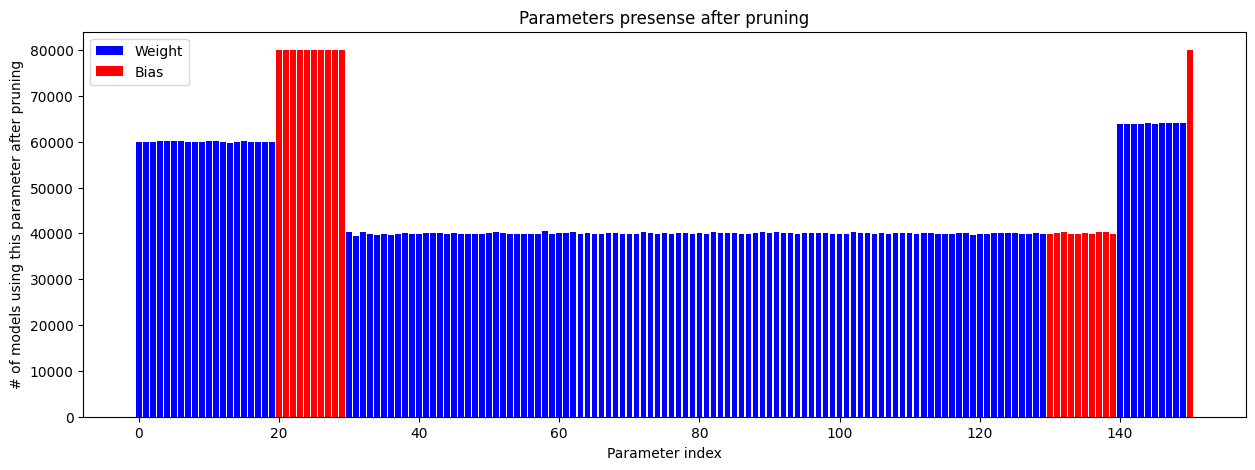

In [8]:
ax = plot_imporance(importance)
plt.show()

100%|██████████| 8/8 [03:12<00:00, 24.06s/it]


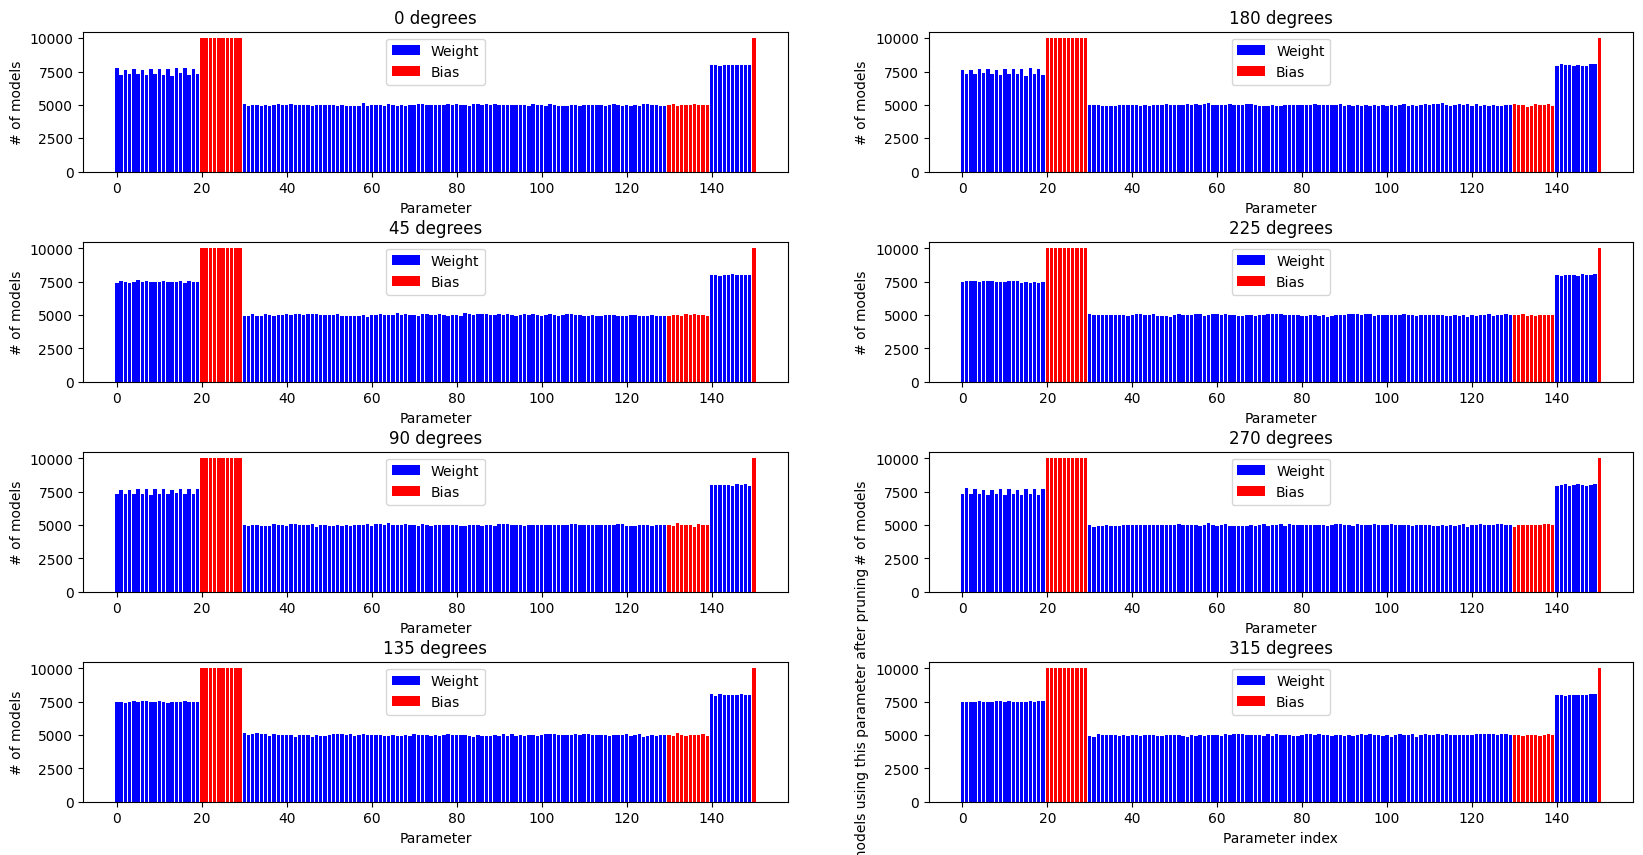

In [66]:
angles = list(range(0,360,45))

handles = [
    Patch(facecolor="blue", label="Weight"),
    Patch(facecolor="red", label="Bias")
]
color = ["blue"]*20 + ["red"]*10 + ["blue"]*100 + ["red"]*10 + ["blue"]*10 + ["red"]

fig, ax = plt.subplots(4, 2, figsize=(20,10))
plt.subplots_adjust(hspace = 0.5)
for angle in tqdm(angles):
    dataset_for_angle = dataset[dataset["angle"] == angle]
    importance, less_than_80 = get_importance_map(dataset_for_angle)
    ax[(angle%180)//45][angle//180].bar(range(len(importance)), importance, color=color)
    ax[(angle%180)//45][angle//180].set_title(f"{angle} degrees")
    ax[(angle%180)//45][angle//180].legend(handles=handles)
    ax[(angle%180)//45][angle//180].set_xlabel('Parameter')
    ax[(angle%180)//45][angle//180].set_ylabel('# of models')

plt.xlabel('Parameter index')
plt.ylabel('# of models using this parameter after pruning')
plt.show()

100%|██████████| 10000/10000 [00:19<00:00, 518.49it/s]


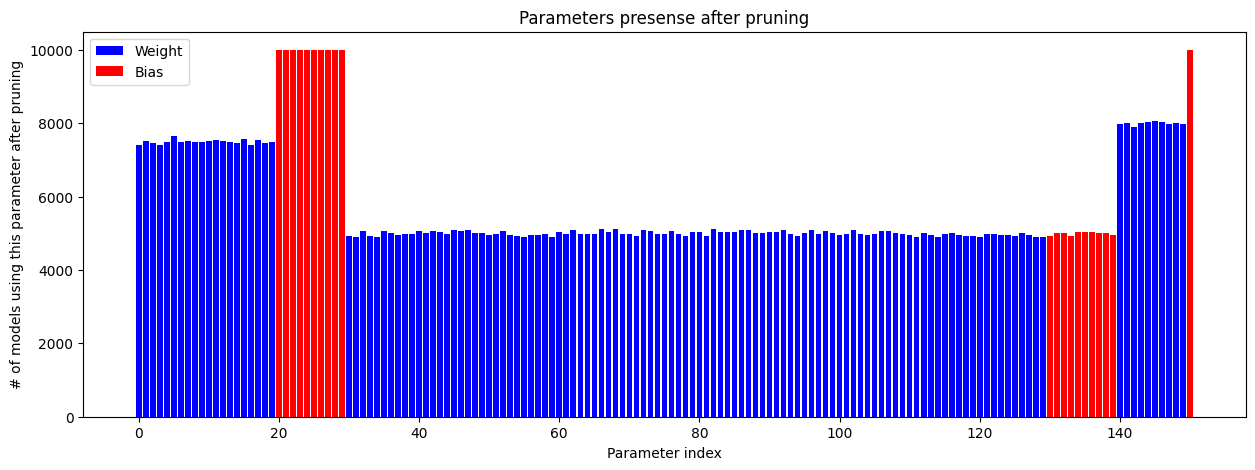

In [11]:
dataset = dataset[dataset["angle"] == 45]
importance, less_than_80 = get_importance_map(dataset)
ax = plot_imporance(importance)
plt.show()

## Projection

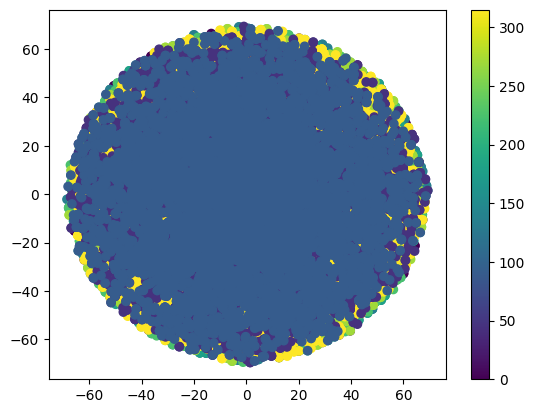

In [13]:
# TSNE

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

df = pd.read_csv("../data/eight_angles.csv")
weights = df.drop(columns=["model_name", "angle"])
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(weights)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df['angle'])
plt.colorbar()
plt.show()

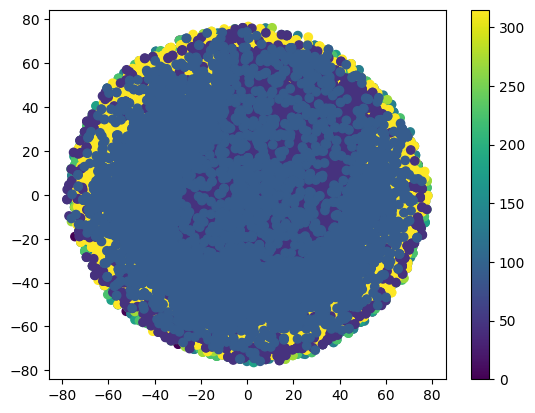

In [14]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

df = pd.read_csv("../data/eight_angles.csv")
weights = df[["weight_0", "weight_1", "weight_2", "weight_3", "weight_4", "weight_5", "weight_6", "weight_7", "weight_8", "weight_9", "weight_10", "weight_11", "weight_12", "weight_13", "weight_14", "weight_15", "weight_16", "weight_17", "weight_18", "weight_19", "weight_20", "weight_21", "weight_22", "weight_23", "weight_24", "weight_25", "weight_26", "weight_27", "weight_28", "weight_29", "weight_140", "weight_141", "weight_142", "weight_143", "weight_144", "weight_145", "weight_146", "weight_147", "weight_148", "weight_149", "weight_150"]]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(weights)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=df['angle'])
plt.colorbar()
plt.show()

## Pruning

In [6]:
def get_discard_map(data, angles, X, y):
    model = MLP(2, [8], 1)

    discard_rate = np.zeros((33))
    discard_map = np.ones((33))

    for i in tqdm(range(len(data))):
        weights = data[i]
        X_rotated = rotate(X, angles[i])

        for j in range(1, 33):
            mask = abs(weights).argsort().argsort() < j
            masked_weights = weights.copy()
            masked_weights[mask] = 0
            list_to_model(model, masked_weights)
            accuracy = get_accuracy(model, X_rotated, y)
            if(accuracy < 95):
                break
        mask = abs(weights).argsort().argsort() < j-1
        discard_rate += (discard_map * mask)
    
    return discard_rate

In [22]:
import numpy as np
from src.model.models import MLP
from src.data.helpers import get_moons_dataset, list_to_model, rotate
from src.visualization.visualize import plot_decision_boundary
from tqdm.notebook import tqdm
from collections import defaultdict


data = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data[:, -1]
data = data[:, 1:-1]


model = MLP(2, [8], 1)

X, y = get_moons_dataset(n_samples=1000, noise=0.1)

In [20]:
discard_rate = get_discard_map(data, angles, X, y)

  0%|          | 0/80000 [00:00<?, ?it/s]

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

plt.rcParams.update({'font.size': 16})

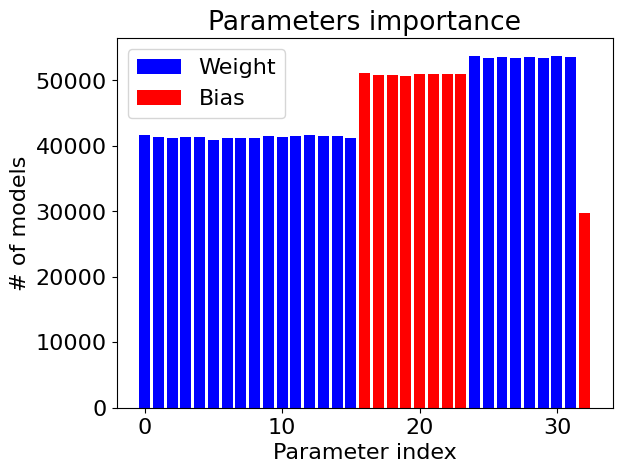

In [21]:

handles = [
        Patch(facecolor="blue", label="Weight"),
        Patch(facecolor="red", label="Bias")
    ]

preserve_rate = 80000 - discard_rate
color = ["blue"]*16 + ["red"]*8 + ["blue"]*8 + ["red"]*1
plt.bar(range(33), preserve_rate, color=color)
plt.title("Parameters importance")
plt.xlabel("Parameter index")
plt.ylabel("# of models")

plt.legend(handles=handles)
plt.show()

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

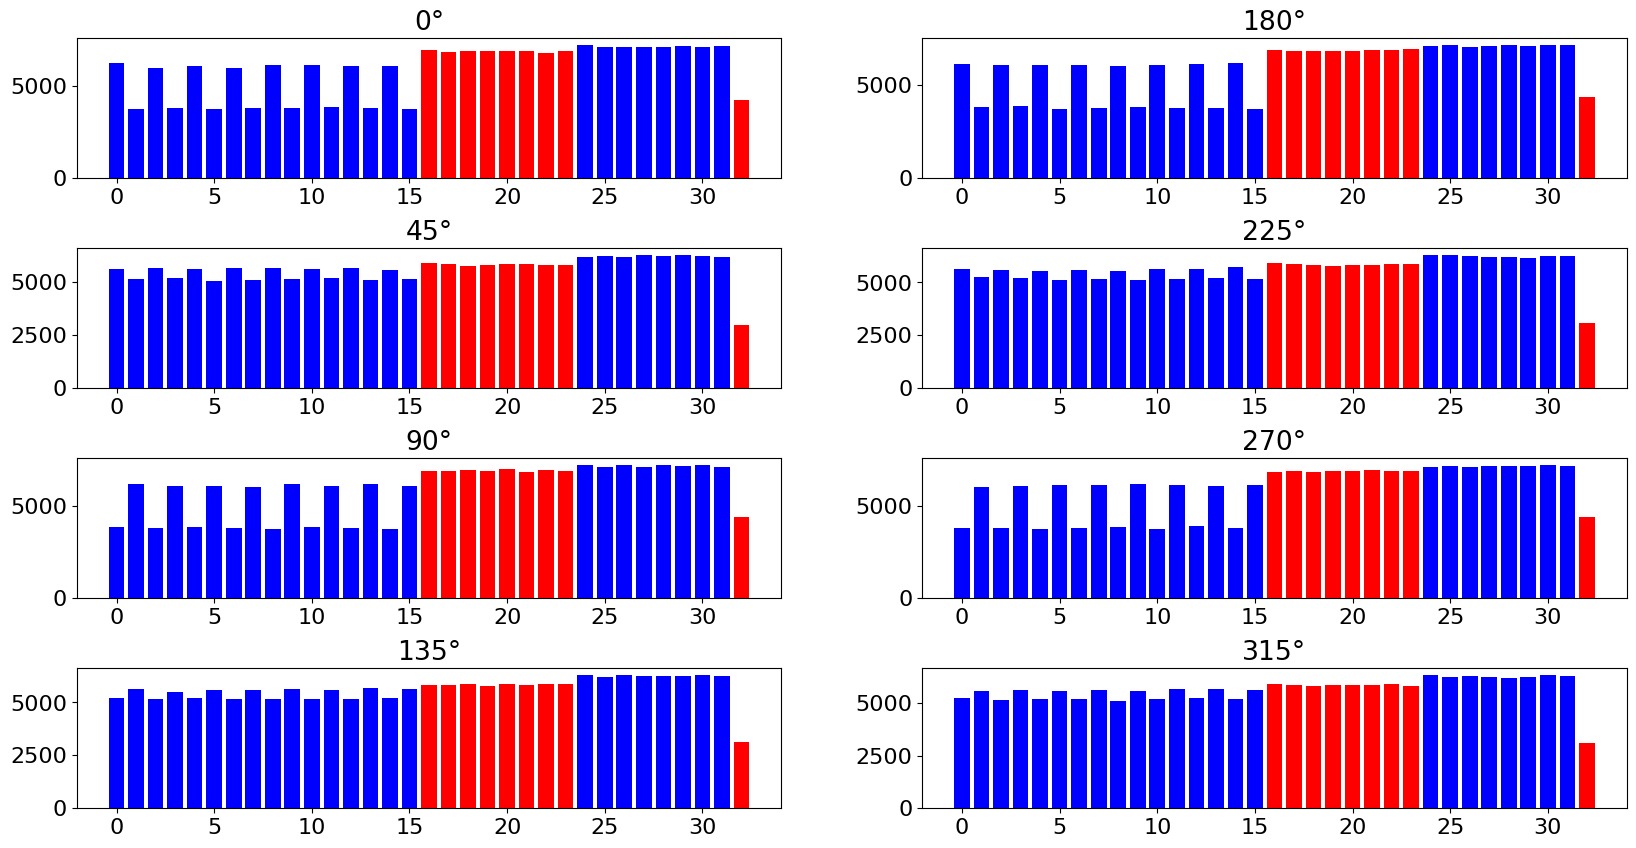

In [16]:
# Per angle pruning

angles = list(range(0,360,45))
dataset = pd.read_csv('../data/eight_angles_small.csv')
X, y = get_moons_dataset(n_samples=1000, noise=0.1)

handles = [
    Patch(facecolor="blue", label="Weight"),
    Patch(facecolor="red", label="Bias")
]
color = ["blue"]*16 + ["red"]*8 + ["blue"]*8 + ["red"]*1

fig, ax = plt.subplots(4, 2, figsize=(20,10))
plt.subplots_adjust(hspace = 0.5)
for angle in tqdm(angles):
    data = dataset[dataset["angle"] == angle]
    angles = data["angle"].to_numpy()
    data = data.drop(columns=["model_name", "angle"]).to_numpy()
    discard_rate = get_discard_map(data, angles, X, y)
    preserve_rate = 10000 - discard_rate

    ax[(angle%180)//45][angle//180].bar(range(len(preserve_rate)), preserve_rate, color=color)
    ax[(angle%180)//45][angle//180].set_title(f"{angle}°")
    # ax[(angle%180)//45][angle//180].legend(handles=handles)
    # ax[(angle%180)//45][angle//180].set_xlabel('Parameter')
    # ax[(angle%180)//45][angle//180].set_ylabel('# of models')

# plt.xlabel('Parameter index')
# plt.ylabel('# of models using this parameter after pruning')
plt.show()

  0%|          | 0/80000 [00:00<?, ?it/s]

Text(0, 0.5, 'Number of models')

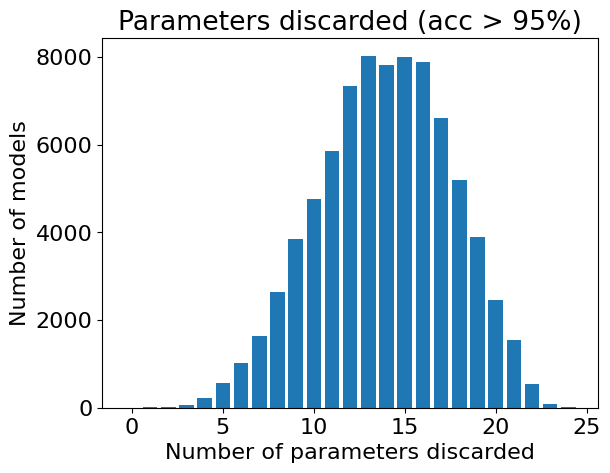

In [23]:
discard_rate = np.zeros((33))
discard_map = np.ones((33))
final_maps = []
discarded_counter = defaultdict(int)

for i in tqdm(range(80000)):
    weights = data[i]
    X_rotated = rotate(X, angles[i])

    for j in range(1, 33):
        mask = abs(weights).argsort().argsort() < j
        masked_weights = weights.copy()
        masked_weights[mask] = 0
        list_to_model(model, masked_weights)
        accuracy = get_accuracy(model, X_rotated, y)
        if(accuracy < 95):
            break
    mask = abs(weights).argsort().argsort() < j-1
    discarded_counter[j-1] += 1
    final_maps.append(mask)
    discard_rate += (discard_map * mask)



Text(0, 0.5, '# of models')

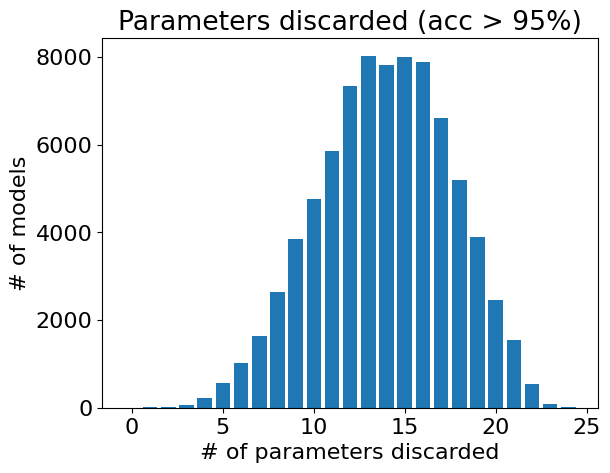

In [25]:
x = list(discarded_counter.keys())
y = list(discarded_counter.values())
plt.bar(x, y)
plt.title("Parameters discarded (acc > 95%)")
plt.xlabel("# of parameters discarded")
plt.ylabel("# of models")

99.9


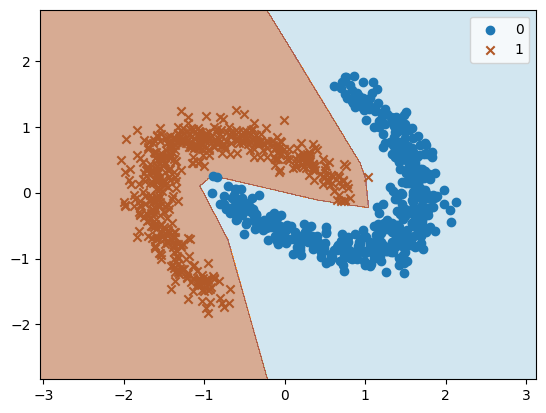

99.9


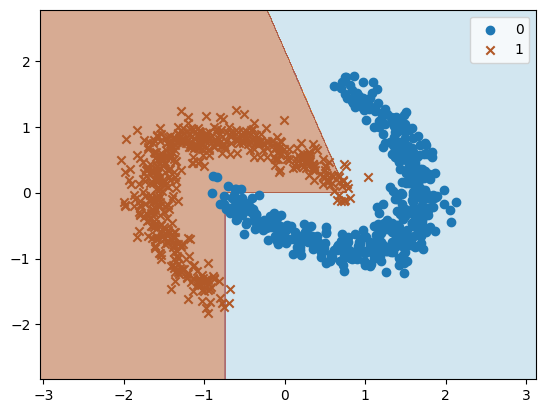

In [81]:
# We can remove 24 parameters and still have 95% accuracy

weights = data[10941]
X_rotated = rotate(X, angles[10941])

mask = abs(weights).argsort().argsort() < 24
masked_weights = weights.copy()
list_to_model(model, masked_weights)
accuracy = get_accuracy(model, X_rotated, y)
print(accuracy)
plot_decision_boundary(model, X_rotated, y)
masked_weights[mask] = 0
list_to_model(model, masked_weights)
print(accuracy)
plot_decision_boundary(model, X_rotated, y)


  0%|          | 0/10000 [00:00<?, ?it/s]

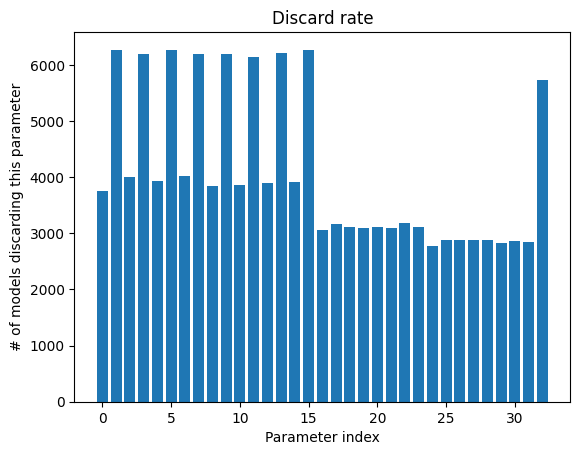

In [104]:
# Only angle 0

data = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data[:10000, -1]
data = data[:10000, 1:-1]
X, y = get_moons_dataset(n_samples=1000, noise=0.1)

discard_rate = get_discard_map(data, X, y)

handles = [
        Patch(facecolor="blue", label="Weight"),
        Patch(facecolor="red", label="Bias")
    ]

preserve_rate = 80000 - discard_rate
color = ["blue"]*16 + ["red"]*8 + ["blue"]*8 + ["red"]*1
plt.bar(range(33), preserve_rate, color=color)
plt.title(f"Parameters importance for 0")
plt.xlabel("Parameter index")
plt.ylabel("# of models using this parameter after pruning")

plt.legend(handles=handles)
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

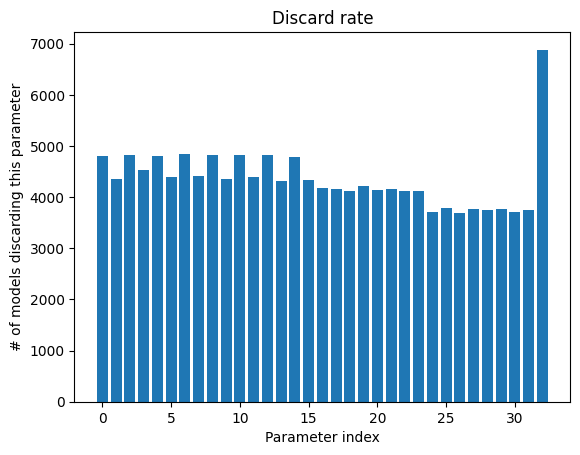

In [108]:
# Only angle 135

data = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data[10000:20000, -1]
data = data[10000:20000, 1:-1]
X, y = get_moons_dataset(n_samples=1000, noise=0.1)

discard_rate = get_discard_map(data, angles, X, y)

plt.bar(range(33), discard_rate)
plt.title("Discard rate")
plt.xlabel("Parameter index")
plt.ylabel("# of models discarding this parameter")
plt.show()

## Projection of the latent space

In [1]:
import torch
import numpy as np
from src.model.models import Autoencoder, MLP
from src.data.helpers import get_moons_dataset, list_to_model, rotate
from src.visualization.visualize import plot_decision_boundary

model = Autoencoder()
model.load_state_dict(torch.load("../models/autoencoder_candidate.pth"))

RuntimeError: Error(s) in loading state_dict for Autoencoder:
	size mismatch for encoder.0.weight: copying a param with shape torch.Size([1024, 33]) from checkpoint, the shape in current model is torch.Size([512, 33]).
	size mismatch for encoder.0.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for encoder.2.weight: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([256, 512]).
	size mismatch for encoder.2.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for encoder.4.weight: copying a param with shape torch.Size([512, 1024]) from checkpoint, the shape in current model is torch.Size([64, 256]).
	size mismatch for encoder.4.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for encoder.6.weight: copying a param with shape torch.Size([256, 512]) from checkpoint, the shape in current model is torch.Size([16, 64]).
	size mismatch for encoder.6.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for encoder.8.weight: copying a param with shape torch.Size([128, 256]) from checkpoint, the shape in current model is torch.Size([10, 16]).
	size mismatch for encoder.8.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([256, 128]) from checkpoint, the shape in current model is torch.Size([16, 10]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([256]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for decoder.2.weight: copying a param with shape torch.Size([512, 256]) from checkpoint, the shape in current model is torch.Size([64, 16]).
	size mismatch for decoder.2.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.4.weight: copying a param with shape torch.Size([1024, 512]) from checkpoint, the shape in current model is torch.Size([256, 64]).
	size mismatch for decoder.4.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for decoder.6.weight: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([512, 256]).
	size mismatch for decoder.6.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).
	size mismatch for decoder.8.weight: copying a param with shape torch.Size([33, 1024]) from checkpoint, the shape in current model is torch.Size([33, 512]).

In [73]:
lantent_mask_1 = X_pca[:,0] < 0
lantent_mask_2 = X_pca[:,0] >= 0

data_1 = data[lantent_mask_1]
data_2 = data[lantent_mask_2]
print(data_1.shape)
print(data_2.shape)

(6475, 33)
(3525, 33)


99.9


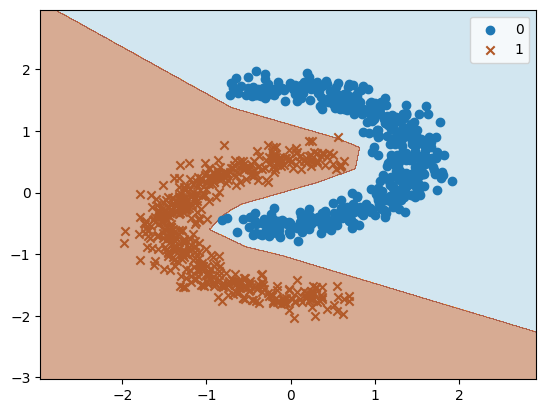

99.3


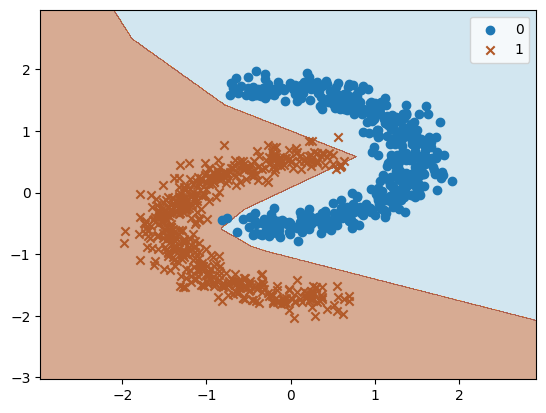

In [74]:
index = 0

model = MLP(2, [8], 1)
weights = data_1[index]
list_to_model(model, weights)
X, y = get_moons_dataset()
X_rotated = rotate(X, 90)
print(get_accuracy(model, X_rotated, y))
plot_decision_boundary(model, X_rotated, y)

weights = data_2[index]
list_to_model(model, weights)
X, y = get_moons_dataset()
X_rotated = rotate(X, 90)
print(get_accuracy(model, X_rotated, y))
plot_decision_boundary(model, X_rotated, y)

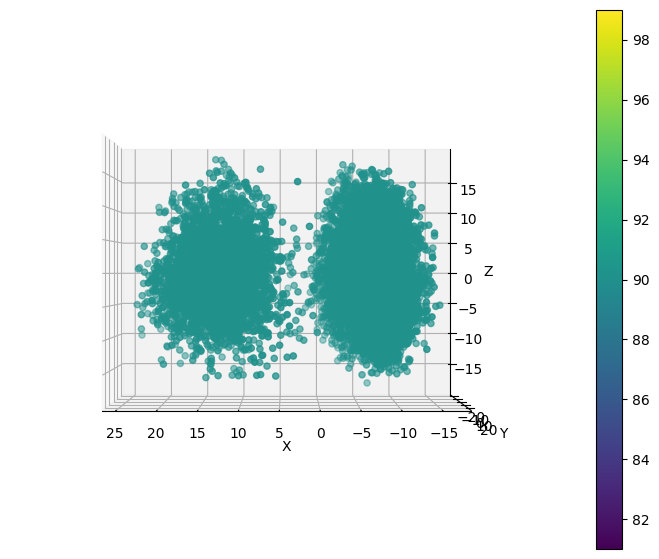

In [28]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent_space)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(0, 90, 0)
plt.show()

## Latent space split investigation

In [1]:
import torch
import numpy as np
from utils.model.models import Autoencoder, MLP
from utils.data.helpers import get_moons_dataset, list_to_model, rotate
from utils.visualization.visualize import plot_decision_boundary

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from collections import defaultdict
from tqdm import tqdm

In [55]:
model = Autoencoder()
model.load_state_dict(torch.load("../models/autoencoder_small.pth"))

data_raw = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data_raw[:, -1]
data = data_raw[:, 1:-1]

mask = (angles == 135)
data = data[mask]
angles = angles[mask]

latent_space = model.encoder(torch.tensor(data).float()).detach().numpy()
print(latent_space.shape)

(10000, 10)


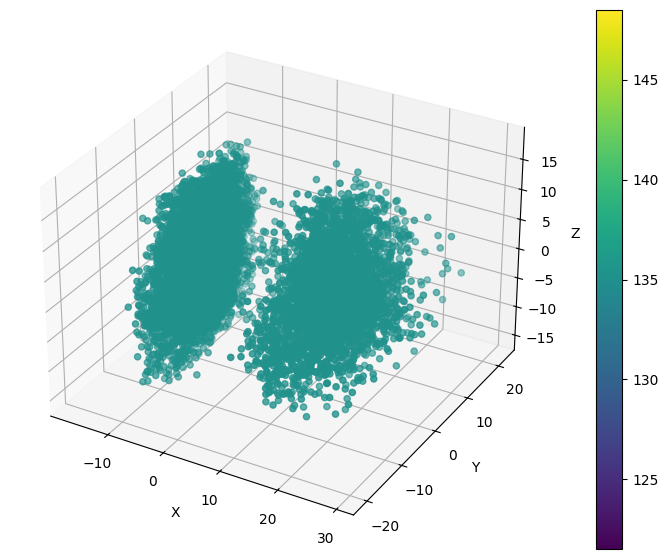

In [56]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(latent_space)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

(6211, 33)
(3789, 33)


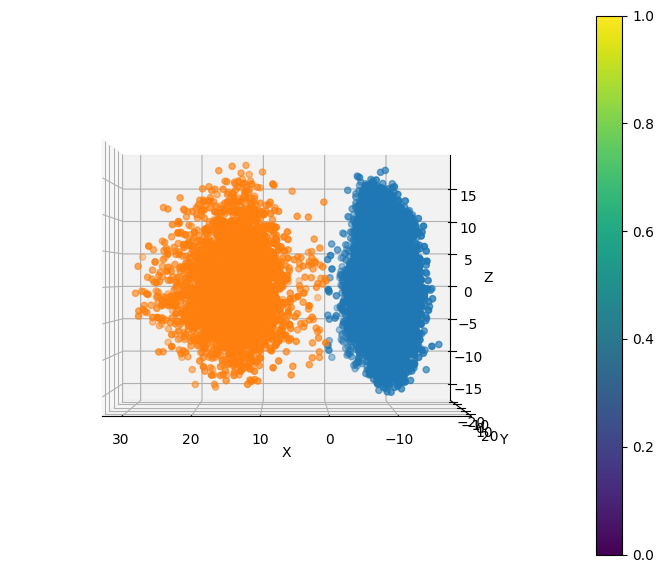

In [57]:
lantent_mask_1 = X_pca[:,0] < 0
lantent_mask_2 = X_pca[:,0] >= 0

data_1 = data[lantent_mask_1]
data_2 = data[lantent_mask_2]
print(data_1.shape)
print(data_2.shape)

X_pca_1 = X_pca[lantent_mask_1]
X_pca_2 = X_pca[lantent_mask_2]
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X_pca_1[:, 0], X_pca_1[:, 1], X_pca_1[:, 2])
img = ax.scatter(X_pca_2[:, 0], X_pca_2[:, 1], X_pca_2[:, 2])
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(0, 90, 0)
plt.show()

In [44]:
def prune(weights: np.array, n: int):
    mask = abs(weights).argsort().argsort() < n
    masked_weights = weights.copy()
    masked_weights[mask] = 0

    return masked_weights, mask

100%|██████████| 6062/6062 [00:48<00:00, 124.22it/s]


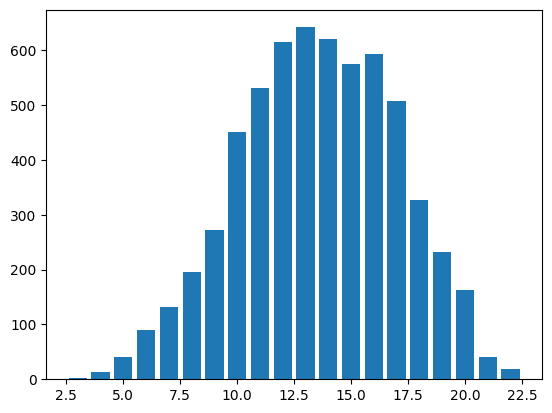

In [50]:
model = MLP(2, [8], 1)
discarded = defaultdict(int)
X, y = get_moons_dataset()
X_rotated = rotate(X, 180)

for weights in tqdm(data_1):
    for n in range(1, 33):
        weights, _ = prune(weights, n)
        list_to_model(model, weights)
        accuracy = get_accuracy(model, X_rotated, y)

        if(accuracy < 95):
            discarded[n-1] += 1
            break

keys = list(discarded.keys())
values = list(discarded.values())

plt.bar(keys, values)
plt.show()

100%|██████████| 3938/3938 [00:30<00:00, 129.35it/s]


defaultdict(<class 'int'>, {9: 245, 12: 374, 13: 411, 15: 401, 14: 377, 11: 329, 17: 288, 5: 27, 20: 83, 10: 288, 8: 174, 6: 69, 16: 354, 18: 195, 19: 147, 7: 115, 3: 2, 4: 15, 21: 36, 22: 8})


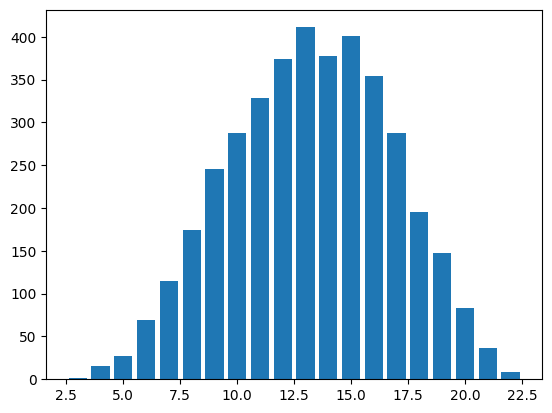

In [49]:
model = MLP(2, [8], 1)
discarded = defaultdict(int)
X, y = get_moons_dataset()
X_rotated = rotate(X, 180)

for weights in tqdm(data_2):
    for n in range(1, 33):
        weights, _ = prune(weights, n)
        list_to_model(model, weights)
        accuracy = get_accuracy(model, X_rotated, y)

        if(accuracy < 95):
            discarded[n-1] += 1
            break

keys = list(discarded.keys())
values = list(discarded.values())
plt.bar(keys, values)
plt.show()

In [137]:
print(data_1[0])
print(data_2[0])

[ 0.97324562  3.34921956  0.6019671  -4.57618761 -2.16936493 -0.16197519
  1.60606337 -0.5220238  -0.96451873 -1.98677027 -0.90406013 -0.10568173
 -1.02939153 -0.94601047  1.28600621 -4.53414345 -2.04156208 -2.16751194
 -1.29790354 -0.4297348  -1.52514827  2.73085499 -1.01494086  2.27106857
 -3.78675199  5.29735994  2.26338005 -1.05978382  1.57290649  1.57179022
  1.19188368 -3.05982661  2.13292146]
[ 0.43540296 -4.74069071 -0.65174311  0.99998504 -2.34533381 -0.32644692
 -0.90808225 -2.27470756  0.19313237 -2.30363393  0.73746359  1.66775179
  0.47545126 -4.01264048 -0.03793341 -0.01014388 -2.44178891  0.7706331
 -1.36846507  3.97348022 -1.14405787  2.46468496  1.96663857 -0.20253468
  2.70812464  0.69352633  1.3072809   1.90712762  1.13045228 -1.4372406
 -3.38886142  0.00772405  1.49624276]


## Accuracy of reconstructed models

In [27]:
class Autoencoder(torch.nn.Module):
    def __init__(self) -> None:
        super(Autoencoder, self).__init__()
        
        self.encoder = self.encoder = torch.nn.Sequential(
            torch.nn.Linear(33, 1024),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(512),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(128),
            torch.nn.Linear(128, 16),
            torch.nn.Tanh(),
        )

        self.decoder = self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, 128),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(128),
            torch.nn.Linear(128, 256),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(512),
            torch.nn.Linear(512, 1024),
            torch.nn.ReLU(),
            torch.nn.BatchNorm1d(1024),
            torch.nn.Linear(1024, 33),
        )

    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output

In [28]:
from src.model.models import MLP
from src.data.helpers import list_to_model, rotate, get_moons_dataset, get_accuracy

import torch
import numpy as np
from tqdm import tqdm

model = MLP(2, [8], 1)
model.eval()
autoencoder = Autoencoder()
autoencoder.load_state_dict(torch.load("../models/autoencoders/experiment8/autoencoder_final.pth"))
autoencoder.eval()

data = np.genfromtxt('../data/eight_angles_small.csv', delimiter=',', skip_header=1)
angles = data[:, -1]
weights = data[:, 1:-1]

X, y = get_moons_dataset(n_samples=1000, noise=0.1)

In [29]:
trained_accuracies = []
reconstructed_accuracies = []

for i in tqdm(range(len(weights))):
    list_to_model(model, weights[i])
    X_rotated = rotate(X, angles[i])
    accuracy = get_accuracy(model, X_rotated, y)
    trained_accuracies.append(accuracy)
    
    weights_tensor = torch.tensor(weights[i]).unsqueeze(0).float()
    reconstructed_weights = autoencoder(weights_tensor).squeeze().detach().numpy()
    list_to_model(model, reconstructed_weights)
    accuracy = get_accuracy(model, X_rotated, y)
    reconstructed_accuracies.append(accuracy)

100%|██████████| 80000/80000 [01:45<00:00, 761.69it/s]


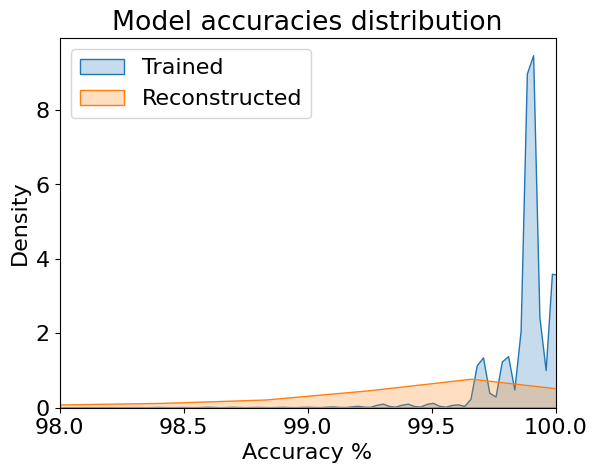

In [32]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns


sns.kdeplot(trained_accuracies, fill=True, label="Trained")
sns.kdeplot(reconstructed_accuracies, fill=True, label="Reconstructed")

plt.xlim(98, 100)
plt.legend(loc="upper left")
plt.title("Model accuracies distribution")
plt.xlabel("Accuracy %")
plt.show()

In [54]:
x = np.array(reconstructed_accuracies)
print(np.sum(x > 95))

76880


In [56]:
print(76880/80000 * 100)

96.1
